In [204]:
import DeepMIMOv3 as DeepMIMO
import matplotlib.pyplot as plt
import numpy as np
from noise import *

In [205]:
def create_dataset(scenario_name, 
                   n_bs_y, n_bs_x, n_ue_y, n_ue_x, 
                   n_paths, n_subcarriers):
    # Load the default params, set constant params
    params = DeepMIMO.default_params()
    params['dataset_folder'] = r'.\scenarios'
    
    # Set params
    # Which scenario
    params['scenario'] = scenario_name
    # For the antennas
    params['bs_antenna']['shape'] = np.array([n_bs_y, n_bs_x])
    params['ue_antenna']['shape'] = np.array([n_ue_y, n_ue_x])
    # For the path
    params['num_paths'] = n_paths
    params['OFDM']['subcarriers'] = n_subcarriers
    
    # Create dataset
    dataset = DeepMIMO.generate_data(params)
    
    return dataset

In [206]:
def generate_H(dataset):
    i = 0  # Only one base station in scenario I2
    j = 0  # Choose the first user
    H = dataset[i]['user']['channel'][j]
    H = H[:, :, 0]  # Choose the first subcarrier
    return H

def generate_H_abs(dataset):
    H = generate_H(dataset)
    H_abs = np.abs(H)

    return H_abs

In [207]:
# Noise functions
def gaussian(H_true, std):
    return np.random.normal(0, std, H_true.shape)

def pink(H_true, amplitude):
    return amplitude*pink_noise(H_true)

In [208]:
# SNR
def calculate_snr(y_true, y_noise): ### write own code later
    # Calculate signal power
    signal_power = np.mean(y_true ** 2)
    # Calculate noise power
    noise_power = np.mean((y_noise - y_true) ** 2)
    # Calculate (linear) SNR
    snr = signal_power / noise_power
    # Convert to dB
    snr_db = 10 * np.log10(snr)
    return snr, snr_db

In [209]:
def generate_noisy_H(H_true, noise):
    # noise = np.random.normal(0, 10**(-5), H.shape)
    std = 10**(-4)
    if noise == gaussian:
        H_added_noise = gaussian(H_true, std)
    elif noise == 'pink':
        H_added_noise = np.zeros(H_true.shape)

    H_noise = H_true + H_added_noise

    return H_noise

In [234]:
def plot_heatmat(H):
    plt.figure(figsize=(8, 6))
    plt.imshow(H.T, cmap='viridis', aspect='auto', origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.title('Channel Gain Magnitude of (RX, TX) Antenna Pairs')
    plt.xlabel('RX antenna')
    plt.ylabel('TX antenna')
    # plt.xticks(ticks=np.arange(H.shape[0]), labels=np.arange(1, H.shape[0] + 1))
    # plt.yticks(ticks=np.arange(H.shape[1]), labels=np.arange(1, H.shape[1] + 1))
    plt.show()

In [235]:
def data_generation(scenario_name, 
                    n_bs_y, n_bs_x, n_ue_y, n_ue_x,
                    n_paths, n_subcarriers):
    dataset = create_dataset(scenario_name, n_bs_y, n_bs_x, n_ue_y, n_ue_x, n_paths, n_subcarriers)
    H_true = generate_H_abs(dataset)
    # plot_environment(dataset)
    return H_true

Change the Environment Here

In [236]:
scenario_name = 'I2_28B'
n_bs_y, n_bs_x = 64, 1
n_ue_y, n_ue_x = 64, 1
n_paths = 5
n_subcarriers = 2

Change Parameters Here

In [237]:
n_datapoints = 100  # number of (total) datapoints generated

# Train/validation/test split parameters
train_size = 0.7
validation_size = 0.2
test_size = 0.1

noise = gaussian

if noise == pink:
    amplitude = 0.0001
    std = None
elif noise == gaussian:
    amplitude = None
    std = 10**(-6)

Generate & Save Datasets


Basestation 1

UE-BS Channels


Reading ray-tracing: 100%|██████████| 402/402 [00:00<00:00, 35953.48it/s]


ToA of some paths of 199 channels with an average total power of 53.50% exceed the useful OFDM symbol duration and are clipped.


Generating channels: 100%|██████████| 201/201 [00:00<00:00, 1962.28it/s]



BS-BS Channels


Generating channels: 100%|██████████| 1/1 [00:00<00:00, 499.50it/s]


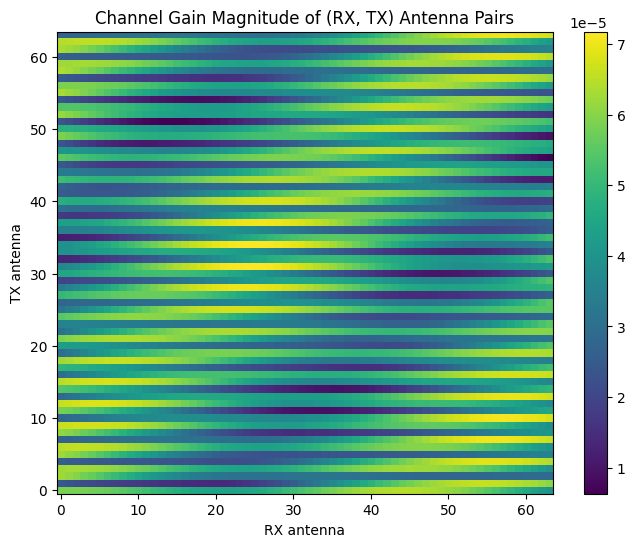

In [238]:
H_true = data_generation(scenario_name,
                        n_bs_y, n_bs_x, n_ue_y, n_ue_x,
                        n_paths, n_subcarriers)

if noise == pink:
    H_added_noise = pink(H_true, amplitude)
elif noise == gaussian:
    H_added_noise = gaussian(H_true, std)

H_noise = H_true + H_added_noise

# If  we need to flatten
# H_true = H_true.reshape(H_true.shape[0]*H_true.shape[1], 1)
# H_noise = H_noise.reshape(H_noise.shape[0]*H_noise.shape[1], 1)

plot_heatmat(H_true)